In [2]:
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc,precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

##### 1. Pearson-based model

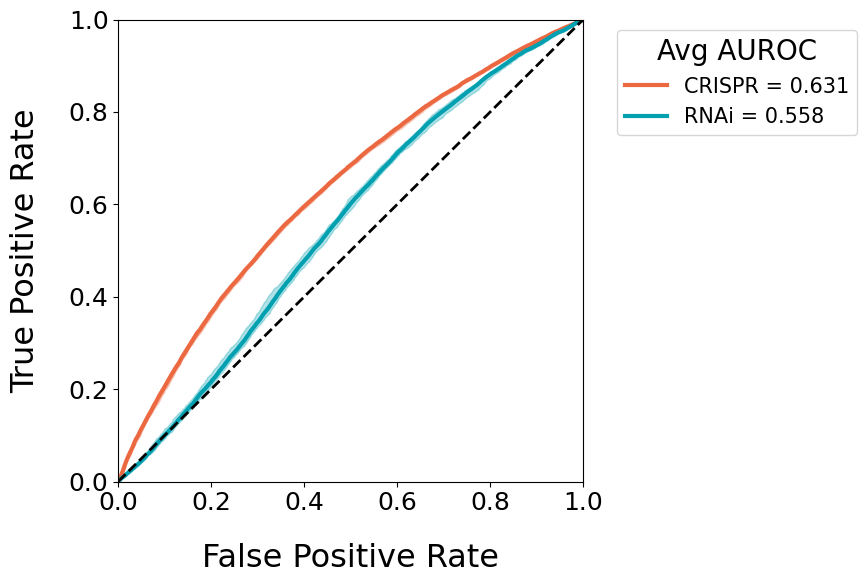

In [3]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

ft_posi_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_posi_seed_key.pkl', 'rb'))
ft_nega_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_nega_seed_key.pkl', 'rb'))

color_key = {'CRISPR':'#eb6841','RNAi':'#00a0b0'}

# draw roc curve
plt.figure(figsize=(6, 6))

for ge_key in ['CRISPR', 'RNAi']:
    ft_posi_seed = ft_posi_seed_key[ge_key]
    ft_nega_seed = ft_nega_seed_key[ge_key]

    n = 0
    auc_lst = []
    df_fpr = pd.DataFrame()
    df_tpr = pd.DataFrame()

    for s in seeds:
        n = n + 1

        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)
        ft_nega = ft_nega_seed[s]
        ft_nega['label'] = [0] * len(ft_nega)
        ft_seed = pd.concat([ft_posi, ft_nega],axis=0)

        # 将皮尔逊相关性系数用作prob
        y_probs = ft_seed['pearson_coeff']
        fpr, tpr, threshold = roc_curve(ft_seed['label'], y_probs,
                                        pos_label=1)


        num_points = 1000
        fpr_fixed = np.linspace(0, 1, num_points)
        tpr_fixed = np.interp(fpr_fixed, fpr, tpr)

        df_fpr[s] = fpr_fixed
        df_tpr[s] = tpr_fixed
        auc_lst.append(auc(fpr, tpr))

    df_fpr['avg'] = np.mean(df_fpr, axis=1)

    df_tpr['avg'] = np.mean(df_tpr, axis=1)
    df_tpr['min'] = np.min(df_tpr, axis=1)
    df_tpr['max'] = np.max(df_tpr, axis=1)

    plt.plot(df_fpr['avg'], df_tpr['avg'], label='{} = {}'.format(ge_key,round(np.mean(auc_lst), 3)), color=color_key[ge_key], lw=3,
             alpha=1)
    plt.fill_between(df_fpr['avg'], df_tpr['min'], df_tpr['max'], color=color_key[ge_key], alpha=0.3, antialiased=False)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=23, labelpad=20)
plt.ylabel('True Positive Rate', fontsize=23, labelpad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=15, markerfirst=True, markerscale=1, scatterpoints=1,
           ncol=1, title_fontsize=20, title='Avg AUROC')
plt.show()

##### 2. ROC curves

In [ ]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

ft_posi_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_posi_seed_key.pkl', 'rb'))
ft_nega_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_nega_seed_key.pkl', 'rb'))

r = {}
for ge_key in ['CRISPR', 'RNAi']:
    ft_posi_seed = ft_posi_seed_key[ge_key]
    ft_nega_seed = ft_nega_seed_key[ge_key]
    X, y, X_train, X_val, X_test, y_train, y_val, y_test = {}, {}, {}, {}, {}, {}, {}, {}
    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)
        ft_nega = ft_nega_seed[s]
        ft_nega['label'] = [0] * len(ft_nega)
        ft = pd.concat([ft_posi, ft_nega],axis=0)

        X[s] = np.array(ft.iloc[:,:-1],dtype='float32')
        y[s] = np.array(ft.iloc[:, [-1]],dtype='float32')
        X_train[s],X_temp,y_train[s],y_temp = train_test_split(X[s],y[s], test_size=0.2, random_state=42)
        X_val[s],X_test[s],y_val[s],y_test[s] = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

    if ge_key == 'CRISPR':
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=9, min_samples_leaf=4)
    else:
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=8, min_samples_leaf=3)

    r[ge_key] = {}

    r[ge_key]['fpr'] = {}
    r[ge_key]['tpr'] = {}
    r[ge_key]['roc_thre'] = {}
    r[ge_key]['auc'] = {}

    r[ge_key]['precision'] = {}
    r[ge_key]['recall'] = {}
    r[ge_key]['pr_thre'] = {}

    for s in tqdm(seeds):
        rf.fit(X_train[s], y_train[s])

        y_pred = rf.predict(X_test[s])
        y_probs = rf.predict_proba(X_test[s])[:, 1]

        fpr, tpr, threshold = roc_curve(y_test[s], y_probs,
                                        pos_label=1)  # Calculate false positive rate, true positive rate, threshold
        auc_ = auc(fpr, tpr)

        r[ge_key]['fpr'][s] = fpr
        r[ge_key]['tpr'][s] = tpr
        r[ge_key]['roc_thre'][s] = threshold
        r[ge_key]['auc'][s] = auc_

        precision, recall, thresholds = precision_recall_curve(y_test[s], y_probs)
        r[ge_key]['precision'][s] = precision
        r[ge_key]['recall'][s] = recall
        r[ge_key]['pr_thre'][s] = thresholds

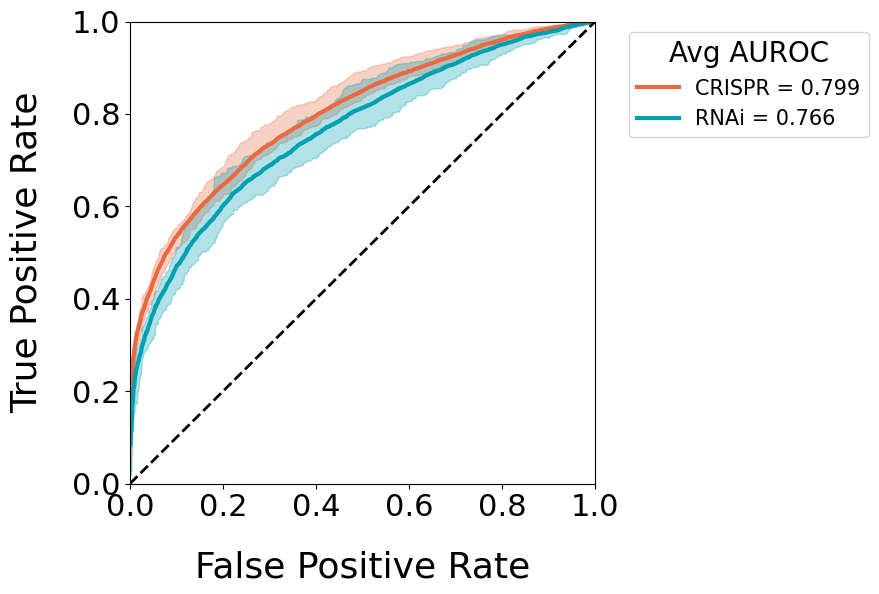

In [4]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

r_roc = pickle.load(open('PCorr_PPI_datasets/r_roc.pkl', 'rb'))

plt.figure(figsize=(6, 6))

r = r_roc['CRISPR']

auc_lst = []
df_fpr = pd.DataFrame()
df_tpr = pd.DataFrame()
for s in seeds:
    fpr, tpr, threshold, auc_ = r['fpr'][s], r['tpr'][s], r['roc_thre'][s], r['auc'][s]

    num_points = 750
    fpr_fixed = np.linspace(0, 1, num_points)
    tpr_fixed = np.interp(fpr_fixed, fpr, tpr)

    df_fpr[s] = fpr_fixed
    df_tpr[s] = tpr_fixed

    auc_lst.append(auc_)

df_fpr['avg'] = np.mean(df_fpr, axis=1)

df_tpr['avg'] = np.mean(df_tpr, axis=1)
df_tpr['min'] = np.min(df_tpr, axis=1)
df_tpr['max'] = np.max(df_tpr, axis=1)

plt.plot(df_fpr['avg'], df_tpr['avg'], label='CRISPR = {}'.format(round(np.mean(auc_lst), 3)), color='#eb6841', lw=3, alpha=1)
plt.fill_between(df_fpr['avg'], df_tpr['min'], df_tpr['max'], color='#eb6841', alpha=0.3, antialiased=False)

r = r_roc['RNAi']

auc_lst = []
df_fpr = pd.DataFrame()
df_tpr = pd.DataFrame()
for s in seeds:
    fpr, tpr, threshold, auc_ = r['fpr'][s], r['tpr'][s], r['roc_thre'][s], r['auc'][s]

    num_points = 1000
    fpr_fixed = np.linspace(0, 1, num_points)
    tpr_fixed = np.interp(fpr_fixed, fpr, tpr)

    df_fpr[s] = fpr_fixed
    df_tpr[s] = tpr_fixed

    auc_lst.append(auc_)

df_fpr['avg'] = np.mean(df_fpr, axis=1)

df_tpr['avg'] = np.mean(df_tpr, axis=1)
df_tpr['min'] = np.min(df_tpr, axis=1)
df_tpr['max'] = np.max(df_tpr, axis=1)

plt.plot(df_fpr['avg'], df_tpr['avg'], label='RNAi = {}'.format(round(np.mean(auc_lst), 3)), color='#00a0b0', lw=3, alpha=1)
plt.fill_between(df_fpr['avg'], df_tpr['min'], df_tpr['max'], color='#00a0b0', alpha=0.3, antialiased=False)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=26, labelpad=20)
plt.ylabel('True Positive Rate', fontsize=26, labelpad=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=15, markerfirst=True, markerscale=1, scatterpoints=1,
           ncol=1, title_fontsize=20,title='Avg AUROC')
plt.rcParams['figure.dpi'] = 100
plt.show()

##### 3. PR curves

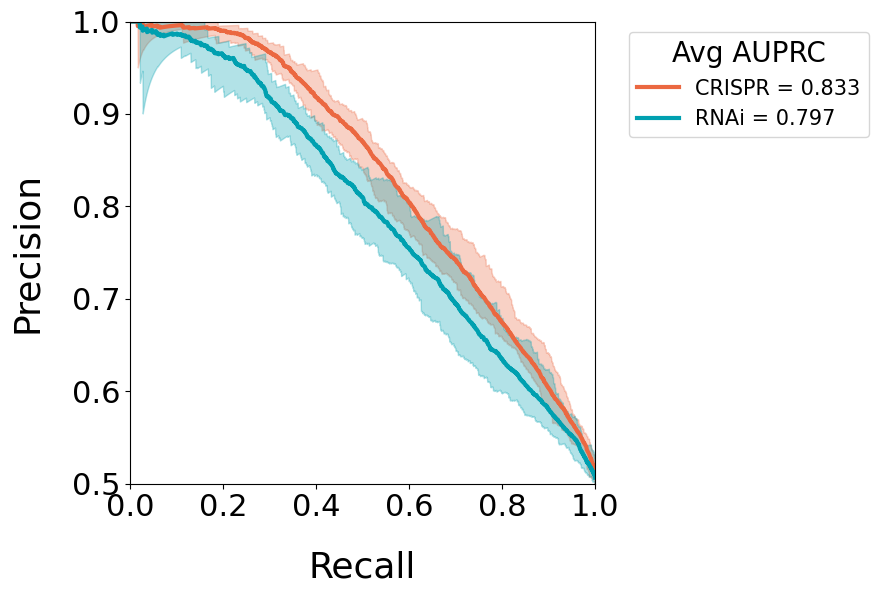

In [5]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

r_roc = pickle.load(open('PCorr_PPI_datasets/r_roc.pkl', 'rb'))

color_key = {'CRISPR':'#eb6841','RNAi':'#00a0b0'}

# draw P-R curve 插值
plt.figure(figsize=(6, 6))
for ge_key in ['CRISPR', 'RNAi']:
    r = r_roc[ge_key]

    auc_lst = []
    df_precision = pd.DataFrame()
    df_recall = pd.DataFrame()
    for s in seeds:
        precision, recall, thresholds = r['precision'][s], r['recall'][s], r['pr_thre'][s]

        recall = np.array(recall[::-1])
        precision = np.array(precision[::-1])

        num_points = 2000
        recall_fixed = np.linspace(0, 1, num_points)
        precision_fixed = np.interp(recall_fixed, recall, precision)

        df_precision[s] = precision_fixed
        df_recall[s] = recall_fixed

        auc_lst.append(auc(recall, precision))


    df_precision['avg'] = np.mean(df_precision, axis=1)
    df_precision['min'] = np.min(df_precision, axis=1)
    df_precision['max'] = np.max(df_precision, axis=1)

    df_recall['avg'] = np.mean(df_recall, axis=1)
    df_recall['min'] = np.min(df_recall, axis=1)
    df_recall['max'] = np.max(df_recall, axis=1)

    plt.plot(df_recall['avg'], df_precision['avg'], label='{} = {}'.format(ge_key,round(np.mean(auc_lst), 3)), color=color_key[ge_key], lw=3,
             alpha=1)
    plt.fill_between(df_recall['avg'], df_precision['min'], df_precision['max'], color=color_key[ge_key], alpha=0.3, antialiased=False)

plt.xlabel('Recall', fontsize=26, labelpad=20)
plt.ylabel('Precision', fontsize=26, labelpad=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0, 1)
plt.ylim(0.5, 1)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=15, markerfirst=True, markerscale=1, scatterpoints=1,
           ncol=1, title_fontsize=20, title='Avg AUPRC')
plt.rcParams['figure.dpi'] = 100
plt.show()

##### 4. TPR/FPR-Threshold curves

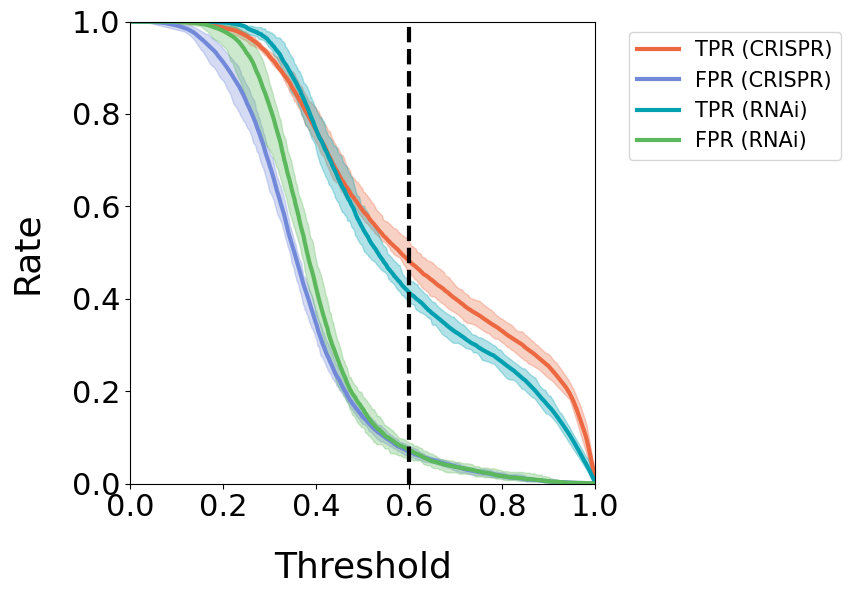

In [6]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

r_roc = pickle.load(open('PCorr_PPI_datasets/r_roc.pkl', 'rb'))

plt.figure(figsize=(6, 6))

r = r_roc['CRISPR']

num_points = 1000
threshold_fixed = np.linspace(0, 1, num_points)

df_threshold = pd.DataFrame()
df_fpr = pd.DataFrame()
df_tpr = pd.DataFrame()
for s in seeds:
    fpr, tpr, threshold = r['fpr'][s], r['tpr'][s], r['roc_thre'][s]
    threshold[0] = 1

    tpr_fixed = np.interp(threshold_fixed, threshold[::-1], tpr[::-1])
    fpr_fixed = np.interp(threshold_fixed, threshold[::-1], fpr[::-1])

    df_threshold[s] = threshold_fixed
    df_tpr[s] = tpr_fixed
    df_fpr[s] = fpr_fixed

df_tpr['avg'] = np.mean(df_tpr, axis=1)
df_tpr['min'] = np.min(df_tpr, axis=1)
df_tpr['max'] = np.max(df_tpr, axis=1)

df_fpr['avg'] = np.mean(df_fpr, axis=1)
df_fpr['min'] = np.min(df_fpr, axis=1)
df_fpr['max'] = np.max(df_fpr, axis=1)

plt.plot(threshold_fixed, df_tpr['avg'], label='TPR (CRISPR)', color='#eb6841', lw=3, alpha=1)
plt.fill_between(threshold_fixed, df_tpr['min'], df_tpr['max'], color='#eb6841', alpha=0.3, antialiased=False)

plt.plot(threshold_fixed, df_fpr['avg'], label='FPR (CRISPR)', color='#7289da', lw=3, alpha=1)
plt.fill_between(threshold_fixed, df_fpr['min'], df_fpr['max'], color='#7289da', alpha=0.3, antialiased=False)

r = r_roc['RNAi']

num_points = 1000
threshold_fixed = np.linspace(0, 1, num_points)

df_threshold = pd.DataFrame()
df_fpr = pd.DataFrame()
df_tpr = pd.DataFrame()
for s in seeds:
    fpr, tpr, threshold = r['fpr'][s], r['tpr'][s], r['roc_thre'][s]
    threshold[0] = 1

    tpr_fixed = np.interp(threshold_fixed, threshold[::-1], tpr[::-1])
    fpr_fixed = np.interp(threshold_fixed, threshold[::-1], fpr[::-1])

    df_threshold[s] = threshold_fixed
    df_tpr[s] = tpr_fixed
    df_fpr[s] = fpr_fixed

df_tpr['avg'] = np.mean(df_tpr, axis=1)
df_tpr['min'] = np.min(df_tpr, axis=1)
df_tpr['max'] = np.max(df_tpr, axis=1)

df_fpr['avg'] = np.mean(df_fpr, axis=1)
df_fpr['min'] = np.min(df_fpr, axis=1)
df_fpr['max'] = np.max(df_fpr, axis=1)

plt.plot(threshold_fixed, df_tpr['avg'], label='TPR (RNAi)', color='#00a0b0', lw=3, alpha=1)
plt.fill_between(threshold_fixed, df_tpr['min'], df_tpr['max'], color='#00a0b0', alpha=0.3, antialiased=False)

plt.plot(threshold_fixed, df_fpr['avg'], label='FPR (RNAi)', color='#5cb85c', lw=3, alpha=1)
plt.fill_between(threshold_fixed, df_fpr['min'], df_fpr['max'], color='#5cb85c', alpha=0.3, antialiased=False)

plt.axvline(x=0.6, ls='--', color='black',lw=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Threshold', fontsize=26, labelpad=20)
plt.ylabel('Rate', fontsize=26, labelpad=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=15, markerfirst=True, markerscale=1, scatterpoints=1,
           ncol=1)
plt.rcParams['figure.dpi'] = 100
plt.show()


##### 5. Feature importance analysis

In [ ]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

ft_posi_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_posi_seed_key.pkl', 'rb'))
ft_nega_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_nega_seed_key.pkl', 'rb'))

feature_list = list(ft_posi_seed_key['CRISPR'][0].columns)

r_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    r = {}

    if ge_key == 'CRISPR':
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=9, min_samples_leaf=4)
    else:
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=8, min_samples_leaf=3)

    ft_posi_seed = ft_posi_seed_key[ge_key]
    ft_nega_seed = ft_nega_seed_key[ge_key]

    X, y, X_train, X_val, X_test, y_train, y_val, y_test = {}, {}, {}, {}, {}, {}, {}, {}
    importance_df = pd.DataFrame()
    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)
        ft_nega = ft_nega_seed[s]
        ft_nega['label'] = [0] * len(ft_nega)

        ft_seed = pd.concat([ft_posi, ft_nega],axis=0)

        X[s] = np.array(ft_seed.iloc[:,:-1],dtype='float32')
        y[s] = np.array(ft_seed.iloc[:, [-1]],dtype='float32')
        X_train[s],X_temp,y_train[s],y_temp = train_test_split(X[s],y[s], test_size=0.2, random_state=42)
        X_val[s],X_test[s],y_val[s],y_test[s] = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

        rf.fit(X_train[s], y_train[s])

        feature_importances = rf.feature_importances_
        importance_df_ = pd.DataFrame({'Importance_{}'.format(s): feature_importances})
        importance_df_.index = feature_list
        importance_df = pd.concat([importance_df, importance_df_], axis=1)

    importance_df['importance'] = np.nanmean(importance_df[['Importance_{}'.format(s) for s in seeds]], axis=1)
    print(importance_df)
    r_key[ge_key] = importance_df

  0%|          | 0/10 [00:00<?, ?it/s]

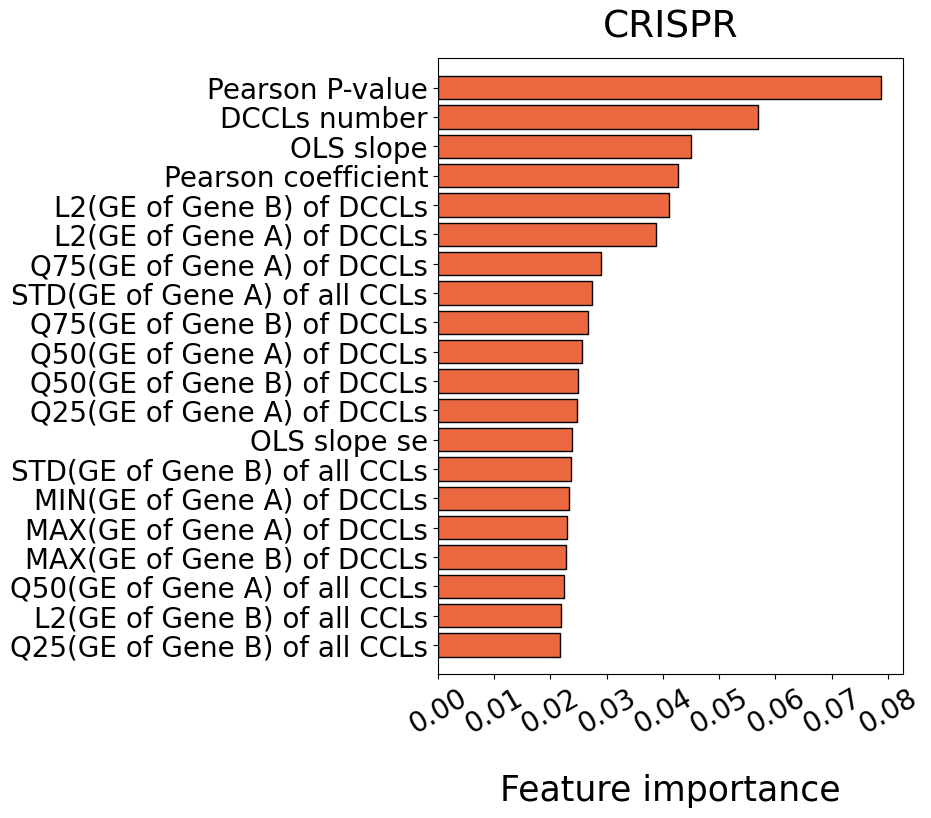

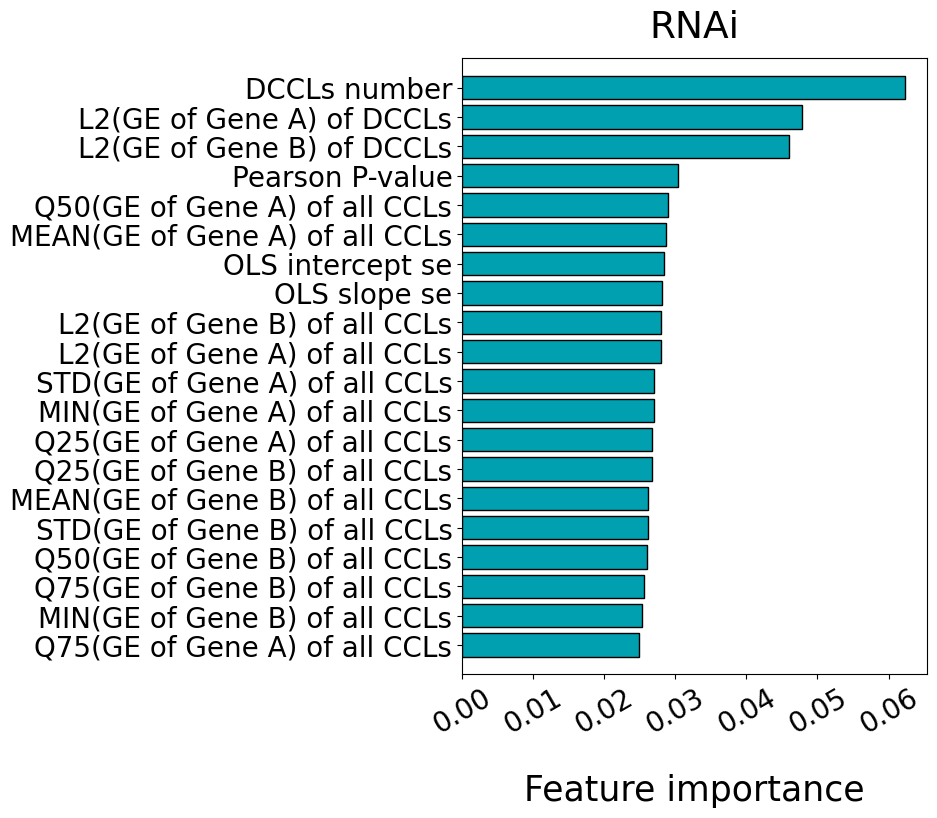

In [27]:
seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

importance_df_key = pickle.load(open('PCorr_PPI_datasets/r_feature.pkl', 'rb'))

features_dict = {'SCCLs_number': 'DCCLs number',
                 'pearson_coeff': 'Pearson coefficient',
                 'pearson_p': 'Pearson P-value',
                 'ols_coeff_1': 'OLS slope',
                 'ols_se_1': 'OLS slope se',
                 'ols_coeff_0': 'OLS intercept',
                 'ols_se_0': 'OLS intercept se',
                 'g1_essen': 'L2(GE of Gene A) of DCCLs',
                 'g2_essen': 'L2(GE of Gene B) of DCCLs',
                 'g1_essen_all': 'L2(GE of Gene A) of all CCLs',
                 'g2_essen_all': 'L2(GE of Gene B) of all CCLs',
                 'g1_mean': 'MEAN(GE of Gene A) of DCCLs',
                 'g2_mean': 'MEAN(GE of Gene B) of DCCLs',
                 'g1_std': 'STD(GE of Gene A) of DCCLs',
                 'g2_std': 'STD(GE of Gene B) of DCCLs',
                 'g1_mean_all': 'MEAN(GE of Gene A) of all CCLs',
                 'g2_mean_all': 'MEAN(GE of Gene B) of all CCLs',
                 'g1_std_all': 'STD(GE of Gene A) of all CCLs',
                 'g2_std_all': 'STD(GE of Gene B) of all CCLs',
                 'g1_min': 'MIN(GE of Gene A) of DCCLs',
                 'g1_25': 'Q25(GE of Gene A) of DCCLs',
                 'g1_50': 'Q50(GE of Gene A) of DCCLs',
                 'g1_75': 'Q75(GE of Gene A) of DCCLs',
                 'g1_max': 'MAX(GE of Gene A) of DCCLs',
                 'g2_min': 'MIN(GE of Gene B) of DCCLs',
                 'g2_25': 'Q25(GE of Gene B) of DCCLs',
                 'g2_50': 'Q50(GE of Gene B) of DCCLs',
                 'g2_75': 'Q75(GE of Gene B) of DCCLs',
                 'g2_max': 'MAX(GE of Gene B) of DCCLs',
                 'g1_min_all': 'MIN(GE of Gene A) of all CCLs',
                 'g1_25_all': 'Q25(GE of Gene A) of all CCLs',
                 'g1_50_all': 'Q50(GE of Gene A) of all CCLs',
                 'g1_75_all': 'Q75(GE of Gene A) of all CCLs',
                 'g1_max_all': 'MAX(GE of Gene A) of all CCLs',
                 'g2_min_all': 'MIN(GE of Gene B) of all CCLs',
                 'g2_25_all': 'Q25(GE of Gene B) of all CCLs',
                 'g2_50_all': 'Q50(GE of Gene B) of all CCLs',
                 'g2_75_all': 'Q75(GE of Gene B) of all CCLs',
                 'g2_max_all': 'MAX(GE of Gene B) of all CCLs',
                 }

color_key = {'CRISPR':'#eb6841','RNAi':'#00a0b0'}

for ge_key in ['CRISPR', 'RNAi']:
    importance_df = importance_df_key[ge_key]
    importance_df = importance_df.sort_values(by='importance', ascending=True).iloc[-20:,:]

    fig, ax = plt.subplots(figsize=(6, 8))
    plt.barh([features_dict[i] for i in importance_df.index], importance_df['importance'], color=color_key[ge_key],
             lw=1, height=0.8,edgecolor='black')
    plt.xticks(fontsize=20, rotation=30, ha='center')
    plt.yticks(fontsize=20)
    plt.ylim(-1,20)
    plt.title(ge_key, fontsize=27, pad=15)
    plt.xlabel('Feature importance', fontsize=25, labelpad=25)
    plt.rcParams['figure.dpi'] = 100
    plt.show()
